# 0) Loading Modules & Data

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.utils import to_categorical

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/FYP")

In [ ]:
# Loading feature files
vocab_level_features_df = pd.read_csv("../Data/Features/vocab_level_features_df.csv")
readability_features_df = pd.read_csv("../Data/Features/readability_features_df.csv")
sentence_vectors = np.load('../Data/Features/sentence_vectors_representation.npy', allow_pickle=True)
chapter_level_features_df = pd.read_csv("../Data/Features/chapter_level_features_df.csv")
final_train_data = pd.read_csv("../data/Processed/final_train_data.csv")

In [ ]:
# Adding Essay Set to Vocab
vocab_level_features_df["essay_set"] = final_train_data["essay_set"]

In [ ]:
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Bidirectional, LSTM, concatenate, Flatten, Dropout

# Define the inputs
vocab_level_input = Input(shape=(vocab_level_features_df.shape[1], 1), name='vocab_level_input')
readability_input = Input(shape=(readability_features_df.shape[1], 1), name='readability_input')
sentence_vector_input = Input(shape=(sentence_vectors[0].shape[0], 1), name='sentence_vector_input')
chapter_level_input = Input(shape=(chapter_level_features_df.shape[1], 1), name='chapter_level_input')

# CNN for vocabulary level features
cnn_vocab_level = Conv1D(filters=64, kernel_size=3, activation='relu')(vocab_level_input)
cnn_vocab_level = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_vocab_level)
cnn_vocab_level = Dropout(0.2)(cnn_vocab_level)
cnn_vocab_level = Flatten()(cnn_vocab_level)  # Flatten the output for the dense layer

# CNN for readability
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu')(readability_input)
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_readability)
cnn_readability = Dropout(0.2)(cnn_readability)
cnn_readability = Flatten()(cnn_readability)

# BiLSTM for sentence vectors
lstm_sentence_vector = Bidirectional(LSTM(64, return_sequences=True))(sentence_vector_input)
lstm_sentence_vector = Bidirectional(LSTM(64))(lstm_sentence_vector)

# First fusion
sentence_level_output = concatenate([cnn_readability, lstm_sentence_vector])

# BiLSTM for chapter level features
lstm_chapter_level = Bidirectional(LSTM(128, return_sequences=True))(chapter_level_input)
lstm_chapter_level = Bidirectional(LSTM(128))(lstm_chapter_level)

# Final fusion
final_fusion = concatenate([cnn_vocab_level, sentence_level_output, lstm_chapter_level])

# Output layer
output = Dense(16, activation='relu')(final_fusion)
output = Dense(1, activation='linear')(output)

# Building the model
model = Model(inputs=[vocab_level_input, readability_input, sentence_vector_input, chapter_level_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 readability_input (InputLa  [(None, 29, 1)]              0         []                            
 yer)                                                                                             
                                                                                                  
 vocab_level_input (InputLa  [(None, 28, 1)]              0         []                            
 yer)                                                                                             
                                                                                                  
 conv1d_10 (Conv1D)          (None, 27, 64)               256       ['readability_input[0][0]']   
                                                                                            

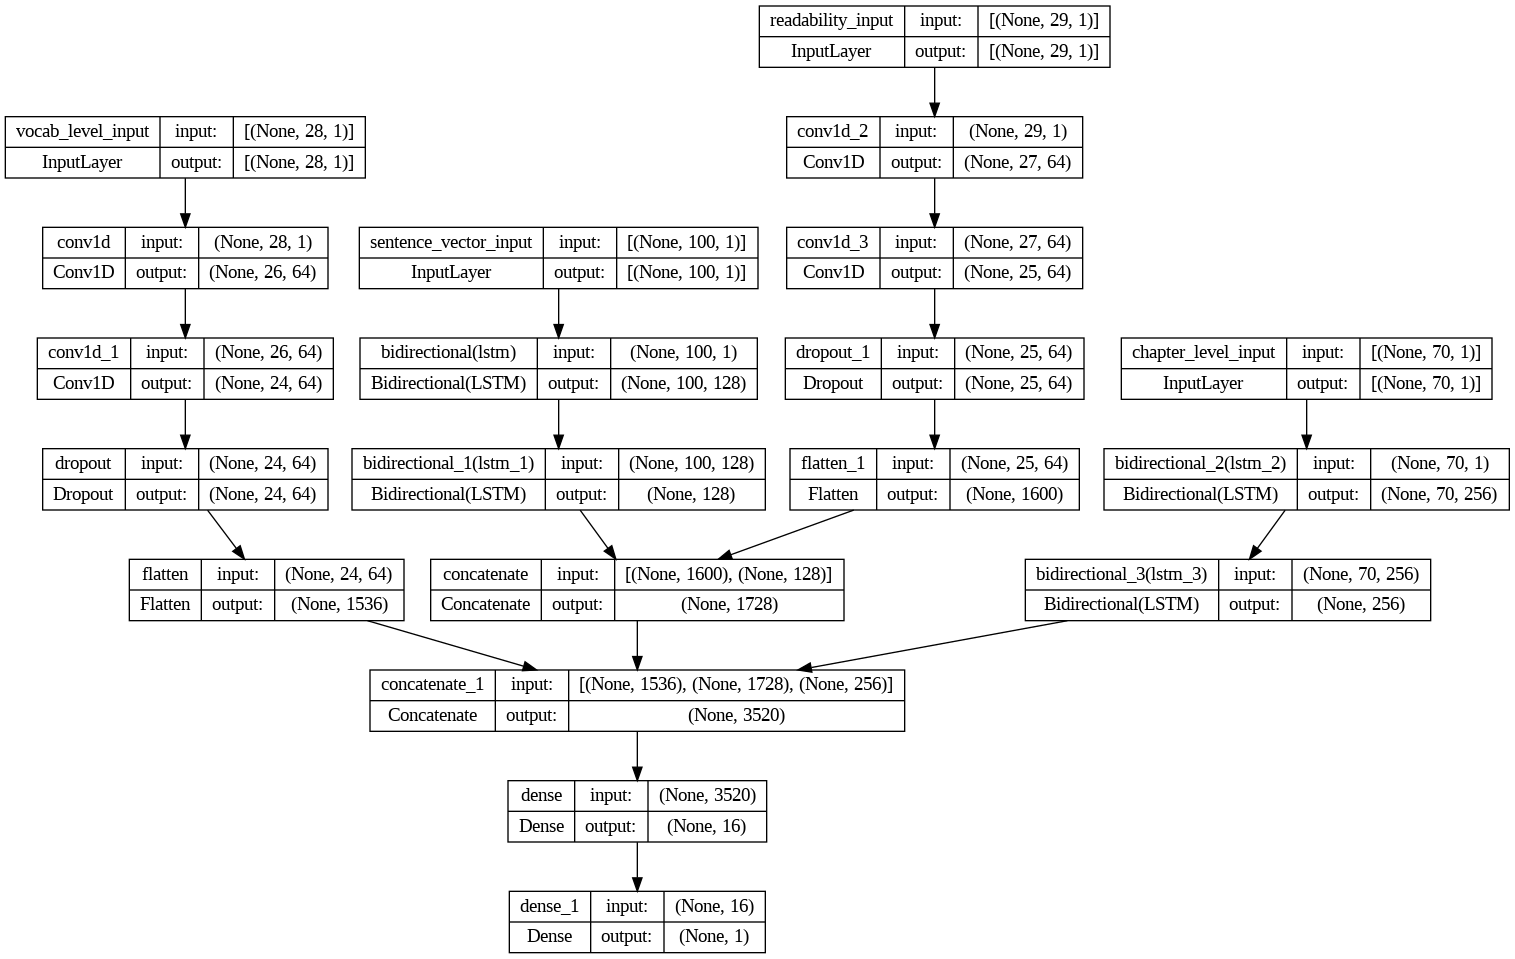

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Reshaping data
vocab_level_features_df = vocab_level_features_df.to_numpy().reshape((-1, vocab_level_features_df.shape[1], 1))
readability_features_df = readability_features_df.to_numpy().reshape((-1, readability_features_df.shape[1], 1))
chapter_level_features_df = chapter_level_features_df.to_numpy().reshape((-1, chapter_level_features_df.shape[1], 1))
sentence_vectors = np.array([i.reshape(-1, 1) for i in sentence_vectors])